# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [219]:
# import libraries
import os
import re
import time
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat,count, desc, explode, lit, min, max, split, stddev, udf, struct
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Normalizer, StandardScaler
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark_dist_explore import hist

In [2]:
# set required environment variable
os.environ['JAVA_HOME'] = "C:\Program Files\Java\jdk1.8.0_221"
os.environ['HADOOP_HOME'] = "C:\hadoop"

In [3]:
# create a Spark session
spark = SparkSession.builder \
    .master("local[4]") \
    .appName("sparkify") \
    .config("spark.network.timeout", "3601s") \
    .config("spark.executor.heartbeatInterval", "3600s") \
    .config("spark.sql.broadcastTimeout", "3600s") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
file_location = 'mini_sparkify_event_data.json'
df = spark.read.json(file_location)
df.persist()
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# The number of records in dataframe
num_records = df.count()
print(num_records)

286500


In [233]:
len(df.columns)

20

In [7]:
# The number of missing data in userId and sessionId columns
df.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in ["userId", "sessionId"]]).show()

+------+---------+
|userId|sessionId|
+------+---------+
|     0|        0|
+------+---------+



In [8]:
# The number and percentage of empty strings in userId column
num_empty_str = df.filter(df["userId"] == "").count()
print("The number of empty strings in userId column:", num_empty_str)
print("The percentage of empty strings in userId column:", round(num_empty_str/num_records,2)*100,"%")

The number of empty strings in userId column: 8346
The percentage of empty strings in userId column: 3.0 %


In [9]:
# The number and percentage of empty strings in sessionId column
num_empty_str = df.filter(df["sessionId"] == "").count()
print("The number of empty strings in sessionId column:", num_empty_str)
print("The per unit value of empty strings in sessionId column:", round(num_empty_str/num_records,2),"%")

The number of empty strings in sessionId column: 0
The per unit value of empty strings in sessionId column: 0.0 %


Having a sessionId without a userId invalidates a record and invalid records will be removed from the dataset.

In [10]:
# Remove rows with empty string in userId column
df = df.filter(df["userId"] != "")

In [11]:
# The current number of records
df.count()

278154

In [12]:
# The minimum timestamp in dataset
result_ms = pd.to_datetime(str(df.select([min("ts")]).collect()[0]['min(ts)']),unit='ms')
print(result_ms)
df.select([min("ts")]).show()

2018-10-01 00:01:57
+-------------+
|      min(ts)|
+-------------+
|1538352117000|
+-------------+



In [13]:
# The maximum timestamp in dataset
result_ms = pd.to_datetime(str(df.select([max("ts")]).collect()[0]['max(ts)']),unit='ms')
print(result_ms)
df.select([max("ts")]).show()

2018-12-03 01:11:16
+-------------+
|      max(ts)|
+-------------+
|1543799476000|
+-------------+



In [14]:
# The time period covered by dataset in days
max_ts = df.select([max("ts")]).collect()[0]['max(ts)']
min_ts = df.select([min("ts")]).collect()[0]['min(ts)']
range_ts = max_ts - min_ts
round(range_ts/(1000*60*60*24))

63

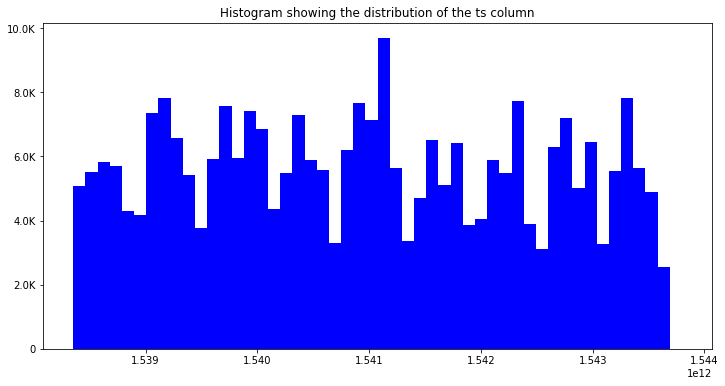

In [15]:
# Show a distribution of the ts column, in order to spot possible outliers
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title("Histogram showing the distribution of the ts column")
hist(ax, df.select("ts"), bins = 50, color=['blue'])
print()

From the above plot, there are no apparent outliers in the ts column. The distribution looks even.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [16]:
# Show the userIds that have the Submit Downgrade event
# Does the level change to free after Submit Downgrade event?
df.select(["userId"]).where(df.page == "Submit Downgrade").orderBy(df.userId.cast("float")).collect()[:5]

[Row(userId='9'),
 Row(userId='11'),
 Row(userId='12'),
 Row(userId='13'),
 Row(userId='13')]

In [17]:
# Does the level change to free after Submit Downgrade event? Yes
df.select(["userId", "firstname", "page", "level"]).where(df.userId == "131").sort("ts").collect()[-80:-75:]

[Row(userId='131', firstname='Kael', page='NextSong', level='paid'),
 Row(userId='131', firstname='Kael', page='NextSong', level='paid'),
 Row(userId='131', firstname='Kael', page='Downgrade', level='paid'),
 Row(userId='131', firstname='Kael', page='Submit Downgrade', level='paid'),
 Row(userId='131', firstname='Kael', page='Home', level='free')]

In [18]:
# Show the userIds that have the Cancellation Confirmation event
df.select(["userId"]).where(df.page == "Cancellation Confirmation").orderBy(df.userId.cast("float")).collect()[:5]

[Row(userId='3'),
 Row(userId='12'),
 Row(userId='17'),
 Row(userId='18'),
 Row(userId='28')]

In [19]:
# Does the level change to free after Cancellation Confirmation event? No, it seems to end the existence of a userId.
df.select(["userId", "firstname", "page", "level"]).where(df.userId == "12").sort("ts").collect()[-5:]

[Row(userId='12', firstname='Sophia', page='NextSong', level='paid'),
 Row(userId='12', firstname='Sophia', page='NextSong', level='paid'),
 Row(userId='12', firstname='Sophia', page='Roll Advert', level='paid'),
 Row(userId='12', firstname='Sophia', page='Cancel', level='paid'),
 Row(userId='12', firstname='Sophia', page='Cancellation Confirmation', level='paid')]

#### Create the Churn column

In [20]:
# create function to check for the Cancellation Confirmation event
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

# Create churn column
df = df.withColumn("churn", flag_cancellation_event("page"))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0)

In [21]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)



#### Exploratory analysis

In [203]:
# The number of unique users in dataset
num_users = df.select("userId").dropDuplicates().count()
print("The number of users in dataset:", num_users)

The number of users in dataset: 225


In [204]:
# The number of churn in dataset
num_churn = df.filter(df["churn"] == 1).count()
print("The number of churned users in dataset:", num_churn)

The number of churned users in dataset: 52


In [205]:
# The relative size of churned users in dataset
print("The percentage of users churned:", round(num_churn/num_users, 2)*100, "%")

The percentage of users churned: 23.0 %


In [206]:
# The percentage of churn in dataset. This will show how much the dataset is skewed.
num_records = df.count()
print("The percentage of churn events in dataset:", round(num_churn/num_records,4)*100,"%")

The percentage of churn events in dataset: 0.02 %


In [207]:
# Using SQL to aid in analysis
df.createOrReplaceTempView("df_table")

# create pandas dataframe from sql view
temp_df = spark.sql('''
          SELECT * FROM df_table
          '''
          )
pd_df = temp_df.toPandas()

# Show data in Pandas dataframe
pd_df.head(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,paid_subscriber
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,1
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,1


In [208]:
# The number and percentage of songs played by churned customers
ids = pd_df[pd_df.churn == 1]["userId"]
temp_df = pd_df[(pd_df["userId"].isin(ids))&(pd_df["page"]=="NextSong")]
song_df = pd_df[(pd_df["page"]=="NextSong")]
num_song_churn = len(temp_df.index)
num_song = len(song_df.index)
del pd_df

print("The number of songs played by churned customers:", num_song_churn, "out of", num_song)
print("The percentage of songs played by churned customers:", round(num_song_churn/num_song, 2)*100, "%")

The number of songs played by churned customers: 36394 out of 228108
The percentage of songs played by churned customers: 16.0 %


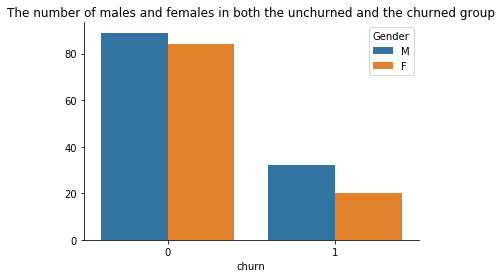

In [197]:
# The comparison of the different genders in both churned and retained customers
tmp_df = df.groupby(["userId"]).agg(F.max("churn").alias("churn"))  # Map userId to churn
tmp_df = tmp_df.select("userId","churn").join(df.select("userId","gender")\
                                                .dropDuplicates(["userId"]), "userId") # Map userId to gender

tmp_df = tmp_df.groupby(["churn", "gender"]).count().sort("churn").toPandas()
ax = sns.barplot(x='churn', y='count', hue='gender', data=tmp_df)
plt.ylabel('')
plt.legend(title='Gender', loc='best')
plt.title('The number of males and females in both the retained and the churned group')
sns.despine(ax=ax);

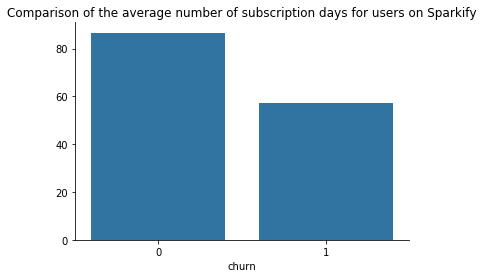

In [211]:
# The average length of time as user for the churned and retained customers
tmp_df = df.select("userId","registration","ts")
tmp_df = tmp_df.withColumn("time_length",(tmp_df.ts-tmp_df.registration)) \
                .groupBy("userId") \
                .agg(F.max("time_length").alias("user_time")) \
                .select("userId", (col("user_time")/1000/60/60/24).alias("user_days")) # Map userId to subscriber duration
tmp_df_2 = df.groupby(["userId"]).agg(F.max("churn").alias("churn")) # Map userId to churn

tmp_df = tmp_df_2.select("userId","churn").join(tmp_df.select("userId","user_days"), "userId")
tmp_df = tmp_df.groupby(["churn"]).agg(F.avg("user_days").alias("average_days")).sort("churn").toPandas()

ax = sns.barplot(data=tmp_df, x='churn', y='average_days', color=sns.color_palette()[0])
plt.ylabel('')
plt.title('Comparison of the average number of subscription days for churned and retained users on Sparkify')
sns.despine(ax=ax);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [30]:
# Display the categories in the page field
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



### Create the Dataset for Model Training

In [31]:
# Make each row of the dataset for modelling represent a user and create the first column
model_df = df.groupby("userId").count().select("userId")
model_df.persist()
model_df.show(10)

+------+
|userId|
+------+
|100010|
|200002|
|   125|
|    51|
|   124|
|     7|
|    54|
|    15|
|   155|
|   132|
+------+
only showing top 10 rows



### The Gender Field

In [32]:
# create gender field corresponding to the userId field
model_df = df.groupby("userId").agg(F.first("gender").alias("gender_"))
model_df.show(10)

+------+-------+
|userId|gender_|
+------+-------+
|100010|      F|
|200002|      M|
|   125|      M|
|   124|      F|
|    51|      M|
|     7|      M|
|    15|      M|
|    54|      F|
|   155|      F|
|100014|      M|
+------+-------+
only showing top 10 rows



In [33]:
# Set binary value for the gender field
set_bin_value = udf(lambda x: 1 if x == "M" else 0, IntegerType())
model_df = model_df.withColumn("gender", set_bin_value("gender_"))
model_df = model_df.drop("gender_")
model_df.show(10)

+------+------+
|userId|gender|
+------+------+
|100010|     0|
|200002|     1|
|   125|     1|
|   124|     0|
|    51|     1|
|     7|     1|
|    15|     1|
|    54|     0|
|   155|     0|
|100014|     1|
+------+------+
only showing top 10 rows



### The Paid Subscriber Field

In [34]:
# Create a column to flag a user, if the user has ever been a paid-level customer
# create function to check for the paid level event
flag_paid_event = udf(lambda x: 1 if x == "paid" else 0, IntegerType())

# Create paid_subscriber column
df = df.withColumn("paid_subscriber", flag_paid_event("level"))
tmp_df = df.groupby("userId").agg(F.max("paid_subscriber").alias("paid_subscriber"))

tmp_df.persist()
model_df.persist()
model_df = model_df.join(tmp_df.select("userId","paid_subscriber"), "userId")
model_df.show(10)

+------+------+---------------+
|userId|gender|paid_subscriber|
+------+------+---------------+
|100010|     0|              0|
|200002|     1|              1|
|   125|     1|              0|
|   124|     0|              1|
|    51|     1|              1|
|     7|     1|              0|
|    15|     1|              1|
|    54|     0|              1|
|   155|     0|              1|
|100014|     1|              1|
+------+------+---------------+
only showing top 10 rows



### The Number of Songs Field

In [35]:
# Create a column based on the number songs each user has played
tmp_df = df.groupBy("userId","page").count()
tmp_df.persist()

def tmp_func(df_row, lookup):
    """ tmp_func takes in a row of the pyspark dataframe and returns the value of
        the count column if the page column has the value in the lookup variable.

    Args:
        df_row (obj): represents a row of pyspark dataframe.
        lookup (string): the value to check for.

    Returns:
        int: The count column value or 0.
    """
    trk = False
    tmp_str = ""
    for i, x in enumerate(df_row):
        if x == lookup and i == 1:
            trk = True
        if i == 2:
            if trk:
                return x
            else: 
                return 0

In [36]:
set_page_mask = udf(lambda row: tmp_func(row, "NextSong"), IntegerType())
tmp_df = tmp_df.withColumn("page_mask", set_page_mask(F.struct([tmp_df[x] for x in tmp_df.columns])))

tmp_df = tmp_df.groupBy("userId").agg(F.max("page_mask").alias("num_songs"))

tmp_df.persist()
model_df.persist()
model_df = model_df.join(tmp_df.select("userId","num_songs"), "userId")

model_df.show(10)

+------+------+---------------+---------+
|userId|gender|paid_subscriber|num_songs|
+------+------+---------------+---------+
|100010|     0|              0|      275|
|200002|     1|              1|      387|
|   125|     1|              0|        8|
|   124|     0|              1|     4079|
|    51|     1|              1|     2111|
|     7|     1|              0|      150|
|    15|     1|              1|     1914|
|    54|     0|              1|     2841|
|   155|     0|              1|      820|
|100014|     1|              1|      257|
+------+------+---------------+---------+
only showing top 10 rows



### The Thumbs Up Field

In [37]:
# Create a column to compute the nummber of thumps up given to songs
tmp_df = df.groupBy("userId","page").count()
tmp_df.persist()

set_page_mask = udf(lambda row: tmp_func(row, "Thumbs Up"), IntegerType())
tmp_df = tmp_df.withColumn("page_mask", set_page_mask(F.struct([tmp_df[x] for x in tmp_df.columns])))

tmp_df = tmp_df.groupBy("userId").agg(F.max("page_mask").alias("thumbs_up"))

tmp_df.persist()
model_df.persist()
model_df = model_df.join(tmp_df.select("userId","thumbs_up"), "userId")

model_df.show(10)

+------+------+---------------+---------+---------+
|userId|gender|paid_subscriber|num_songs|thumbs_up|
+------+------+---------------+---------+---------+
|100010|     0|              0|      275|       17|
|200002|     1|              1|      387|       21|
|   125|     1|              0|        8|        0|
|   124|     0|              1|     4079|      171|
|    51|     1|              1|     2111|      100|
|     7|     1|              0|      150|        7|
|    15|     1|              1|     1914|       81|
|    54|     0|              1|     2841|      163|
|   155|     0|              1|      820|       58|
|100014|     1|              1|      257|       17|
+------+------+---------------+---------+---------+
only showing top 10 rows



### The Thumbs Down Field

In [38]:
# Create a column to compute the nummber of thumps down given to songs
tmp_df = df.groupBy("userId","page").count()
tmp_df.persist()

set_page_mask = udf(lambda row: tmp_func(row, "Thumbs Down"), IntegerType())
tmp_df = tmp_df.withColumn("page_mask", set_page_mask(F.struct([tmp_df[x] for x in tmp_df.columns])))

tmp_df = tmp_df.groupBy("userId").agg(F.max("page_mask").alias("thumbs_down"))

tmp_df.persist()
model_df.persist()
model_df = model_df.join(tmp_df.select("userId","thumbs_down"), "userId")

model_df.show(10)

+------+------+---------------+---------+---------+-----------+
|userId|gender|paid_subscriber|num_songs|thumbs_up|thumbs_down|
+------+------+---------------+---------+---------+-----------+
|100010|     0|              0|      275|       17|          5|
|200002|     1|              1|      387|       21|          6|
|   125|     1|              0|        8|        0|          0|
|   124|     0|              1|     4079|      171|         41|
|    51|     1|              1|     2111|      100|         21|
|     7|     1|              0|      150|        7|          1|
|    15|     1|              1|     1914|       81|         14|
|    54|     0|              1|     2841|      163|         29|
|   155|     0|              1|      820|       58|          3|
|100014|     1|              1|      257|       17|          3|
+------+------+---------------+---------+---------+-----------+
only showing top 10 rows



### The Duration Field

In [39]:
def duration_func(df_row):
    """ duration_func takes in a row of the pyspark dataframe and returns the difference
        between the registration_date and the latest_time column in days.

    Args:
        df_row (obj): represents a row of pyspark dataframe.

    Returns:
        float: The duration of subscription.
    """
    tmp_val_1 = 0
    tmp_val_2 = 0
    for i, x in enumerate(df_row):
        if i == 1:
            tmp_val_1 = float(x)
        elif i == 2:
            tmp_val_2 = float(x)
            return round((tmp_val_2 - tmp_val_1)/(1000*60*60*24), 2)

In [40]:
# Create the duration column to capture how long a user has been a subscriber
tmp_df = df.groupby("userId").agg(F.max("registration").alias("registration_date"))
tmp_df_2 = df.groupby("userId").agg(F.max("ts").alias("latest_time"))
tmp_df.persist()
model_df.persist()
tmp_df = tmp_df.join(tmp_df_2.select("userId","latest_time"), "userId")

set_duration = udf(lambda row: duration_func(row), FloatType())
tmp_df = tmp_df.withColumn("duration", set_duration(F.struct([tmp_df[x] for x in tmp_df.columns])))

tmp_df.persist()
model_df.persist()
model_df = model_df.join(tmp_df.select("userId","duration"), "userId")

model_df.show(10)

+------+------+---------------+---------+---------+-----------+--------+
|userId|gender|paid_subscriber|num_songs|thumbs_up|thumbs_down|duration|
+------+------+---------------+---------+---------+-----------+--------+
|100010|     0|              0|      275|       17|          5| 55.6437|
|200002|     1|              1|      387|       21|          6| 70.0746|
|   125|     1|              0|        8|        0|          0| 71.3169|
|   124|     0|              1|     4079|      171|         41|131.5559|
|    51|     1|              1|     2111|      100|         21| 19.4558|
|     7|     1|              0|      150|        7|          1| 72.7782|
|    15|     1|              1|     1914|       81|         14| 56.5136|
|    54|     0|              1|     2841|      163|         29|110.7517|
|   155|     0|              1|      820|       58|          3|  23.556|
|100014|     1|              1|      257|       17|          3| 85.0834|
+------+------+---------------+---------+---------+

### Append Label

In [41]:
# create the label column
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

tmp_df = df.groupby("userId").agg(F.max("churn").alias("churn"))
tmp_df.persist()
model_df.persist()
model_df = model_df.join(tmp_df.select("userId","churn"), "userId")
model_df.show(10)

+------+------+---------------+---------+---------+-----------+--------+-----+
|userId|gender|paid_subscriber|num_songs|thumbs_up|thumbs_down|duration|churn|
+------+------+---------------+---------+---------+-----------+--------+-----+
|100010|     0|              0|      275|       17|          5| 55.6437|    0|
|200002|     1|              1|      387|       21|          6| 70.0746|    0|
|   125|     1|              0|        8|        0|          0| 71.3169|    1|
|   124|     0|              1|     4079|      171|         41|131.5559|    0|
|    51|     1|              1|     2111|      100|         21| 19.4558|    1|
|     7|     1|              0|      150|        7|          1| 72.7782|    0|
|    15|     1|              1|     1914|       81|         14| 56.5136|    0|
|    54|     0|              1|     2841|      163|         29|110.7517|    1|
|   155|     0|              1|      820|       58|          3|  23.556|    0|
|100014|     1|              1|      257|       17| 

### Prepare Features for Modeling

In [46]:
# Drop the userId column
model_df = model_df.drop("userId")
model_df.show(10)

+------+---------------+---------+---------+-----------+--------+-----+
|gender|paid_subscriber|num_songs|thumbs_up|thumbs_down|duration|churn|
+------+---------------+---------+---------+-----------+--------+-----+
|     0|              0|      275|       17|          5| 55.6437|    0|
|     1|              1|      387|       21|          6| 70.0746|    0|
|     1|              0|        8|        0|          0| 71.3169|    1|
|     0|              1|     4079|      171|         41|131.5559|    0|
|     1|              1|     2111|      100|         21| 19.4558|    1|
|     1|              0|      150|        7|          1| 72.7782|    0|
|     1|              1|     1914|       81|         14| 56.5136|    0|
|     0|              1|     2841|      163|         29|110.7517|    1|
|     0|              1|      820|       58|          3|  23.556|    0|
|     1|              1|      257|       17|          3| 85.0834|    1|
+------+---------------+---------+---------+-----------+--------

In [47]:
# create a vector from the fields created above
assembler = VectorAssembler(inputCols=["gender", "paid_subscriber", "num_songs", "thumbs_up", "thumbs_down", "duration"],\
                            outputCol="features")
model_df = assembler.transform(model_df)
model_df.show(10)

+------+---------------+---------+---------+-----------+--------+-----+--------------------+
|gender|paid_subscriber|num_songs|thumbs_up|thumbs_down|duration|churn|            features|
+------+---------------+---------+---------+-----------+--------+-----+--------------------+
|     0|              0|      275|       17|          5| 55.6437|    0|[0.0,0.0,275.0,17...|
|     1|              1|      387|       21|          6| 70.0746|    0|[1.0,1.0,387.0,21...|
|     1|              0|        8|        0|          0| 71.3169|    1|[1.0,0.0,8.0,0.0,...|
|     0|              1|     4079|      171|         41|131.5559|    0|[0.0,1.0,4079.0,1...|
|     1|              1|     2111|      100|         21| 19.4558|    1|[1.0,1.0,2111.0,1...|
|     1|              0|      150|        7|          1| 72.7782|    0|[1.0,0.0,150.0,7....|
|     1|              1|     1914|       81|         14| 56.5136|    0|[1.0,1.0,1914.0,8...|
|     0|              1|     2841|      163|         29|110.7517|    1

### Min-Max Scaling

In [48]:
# Apply min-max scaling to scale features between 0 & 1
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scalerModel = scaler.fit(model_df)
model_df = scalerModel.transform(model_df)
model_df.show(10)

+------+---------------+---------+---------+-----------+--------+-----+--------------------+--------------------+
|gender|paid_subscriber|num_songs|thumbs_up|thumbs_down|duration|churn|            features|     scaled_features|
+------+---------------+---------+---------+-----------+--------+-----+--------------------+--------------------+
|     0|              0|      275|       17|          5| 55.6437|    0|[0.0,0.0,275.0,17...|[0.0,0.0,0.034004...|
|     1|              1|      387|       21|          6| 70.0746|    0|[1.0,1.0,387.0,21...|[1.0,1.0,0.048006...|
|     1|              0|        8|        0|          0| 71.3169|    1|[1.0,0.0,8.0,0.0,...|[1.0,0.0,6.250781...|
|     0|              1|     4079|      171|         41|131.5559|    0|[0.0,1.0,4079.0,1...|[0.0,1.0,0.509563...|
|     1|              1|     2111|      100|         21| 19.4558|    1|[1.0,1.0,2111.0,1...|[1.0,1.0,0.263532...|
|     1|              0|      150|        7|          1| 72.7782|    0|[1.0,0.0,150.0,7.

In [50]:
data_set = model_df.select(col("churn").alias("label"), col("scaled_features").alias("features"))
data_set.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.0,0.0,0.034004...|
|    0|[1.0,1.0,0.048006...|
|    1|[1.0,0.0,6.250781...|
|    0|[0.0,1.0,0.509563...|
|    1|[1.0,1.0,0.263532...|
|    0|[1.0,0.0,0.018377...|
|    0|[1.0,1.0,0.238904...|
|    1|[0.0,1.0,0.354794...|
|    0|[0.0,1.0,0.102137...|
|    1|[1.0,1.0,0.031753...|
+-----+--------------------+
only showing top 10 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [51]:
# Split the full dataset into train, test, and validation sets
train, test, validation = data_set.randomSplit([0.6, 0.2, 0.2], seed=42)

### Logistic Regression

In [123]:
# create logistic regression model
log_reg =  LogisticRegression(maxIter=20) # Default maxIter=100
start = time.time()
log_reg_model = log_reg.fit(train)
stop = time.time()
print('Training time:', round(stop-start, 1), 'seconds')
val_prediction = log_reg_model.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='label')
acc_score = evaluator.evaluate(val_prediction, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(val_prediction, {evaluator.metricName: "f1"})
print('Accuracy:', round(acc_score, 4))
print('F1-score:', round(f1_score, 4))

Training time: 38.1 seconds
Accuracy: 0.5625
F1-score: 0.405


### Decision Trees

In [124]:
dec_tree = DecisionTreeClassifier(maxDepth=5, seed=42)
start = time.time()
dec_tree_model = dec_tree.fit(train)
stop = time.time()
print('Training time:', round(stop-start, 1), 'seconds')
val_prediction = dec_tree_model.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='label')
acc_score = evaluator.evaluate(val_prediction, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(val_prediction, {evaluator.metricName: "f1"})
print('Accuracy:', round(acc_score, 4))
print('F1-score:', round(f1_score, 4))

Training time: 14.9 seconds
Accuracy: 0.75
F1-score: 0.7227


### Gradient Boosted Trees

In [125]:
# create the Gradient-Boosted Trees model
gb_tree =  GBTClassifier(maxIter=20, seed=42)
start = time.time()
gb_tree_model = gb_tree.fit(train)
stop = time.time()
print('Training time:', round(stop-start, 1), 'seconds')
val_prediction = gb_tree_model.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='label')
acc_score = evaluator.evaluate(val_prediction, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(val_prediction, {evaluator.metricName: "f1"})
print('Accuracy:', round(acc_score, 4))
print('F1-score:', round(f1_score, 4))

Training time: 248.9 seconds
Accuracy: 0.6875
F1-score: 0.6347


### Tune Best Model

In [126]:
# define parameter grid
paramGrid = ParamGridBuilder() \
            .addGrid(dec_tree.maxDepth,[4, 5]) \
            .addGrid(dec_tree.maxBins, [32, 33]) \
            .build()

# create evaluator
evaluator = MulticlassClassificationEvaluator(metricName='f1')

# define the CrossValidator
cross_val = CrossValidator(estimator=dec_tree,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,
                          seed=42)

In [127]:
start = time.time()
cv_model = cross_val.fit(train)
stop = time.time()
print('Training time:', round(stop-start, 1), 'seconds')

Training time: 187.6 seconds


In [198]:
best_model = cv_model.bestModel
val_prediction = best_model.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='label')
acc_score = evaluator.evaluate(val_prediction, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(val_prediction, {evaluator.metricName: "f1"})
print('Accuracy:', round(acc_score, 4))
print('F1-score:', round(f1_score, 4))

Accuracy: 0.6875
F1-score: 0.6347


In [199]:
# Optimal parameters
print('maxDepth:', best_model._java_obj.getMaxDepth())
print('maxBins:', best_model._java_obj.getMaxBins())

maxDepth: 4
maxBins: 32


### The Best model

In [234]:
dec_tree = DecisionTreeClassifier(maxDepth=5, seed=42)
start = time.time()
dec_tree_model = dec_tree.fit(train)
stop = time.time()
print('Training time:', round(stop-start, 1), 'seconds')

test_prediction = dec_tree_model.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='label')
acc_score = evaluator.evaluate(test_prediction, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(test_prediction, {evaluator.metricName: "f1"})
print('Accuracy:', round(acc_score, 4))
print('F1-score:', round(f1_score, 4))

Training time: 19.2 seconds
Accuracy: 0.7222
F1-score: 0.7373


In [235]:
# Optimal parameters
print('maxDepth:', dec_tree_model._java_obj.getMaxDepth())
print('maxBins:', dec_tree_model._java_obj.getMaxBins())

maxDepth: 5
maxBins: 32


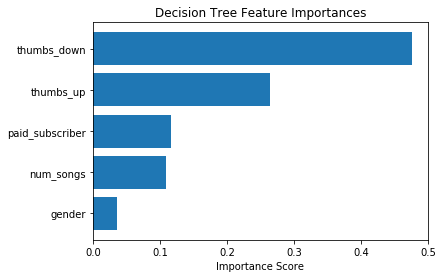

In [227]:
feat_importance = dec_tree_model.featureImportances.values
cols = ["gender", "paid_subscriber", "num_songs", "thumbs_up", "thumbs_down"]
y_tick = np.arange(len(cols))
indices =  np.argsort(feat_importance)[:]

plt.barh(y_tick, feat_importance[indices], align='center')
plt.yticks(y_tick, np.array(cols)[indices])
plt.xlabel('Importance Score')
plt.title('Decision Tree Feature Importances');

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.